<a href="https://colab.research.google.com/github/sudotouchwoman/math-misc/blob/main/notebooks/ensemble-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to ML. Homework 5 by Teterin Nikita, ML-11 Fall 2021**


## **Property pricing problem** 🏠

### **Fetching the data**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

np.random.seed(100)

In [ ]:
sns.set()

In [ ]:
test_dataset_raw = pd.read_feather('https://github.com/sudotouchwoman/park_sem1_ML/blob/master/Test.feather?raw=true')
train_dataset_raw = pd.read_feather('https://github.com/sudotouchwoman/park_sem1_ML/blob/master/Train.feather?raw=true')

In [ ]:
test_dataset_raw

In [ ]:
train_dataset_raw

In [ ]:
train_dataset_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
id,100000.0,4.999950e+04,2.886766e+04,0.0,24999.75,49999.5,74999.25,99999.0
street_id,100000.0,3.359416e+02,1.936955e+02,0.0,169.00,336.0,503.00,671.0
build_tech,70062.0,5.314293e-01,5.776793e-01,0.0,0.00,0.0,1.00,2.0
floor,100000.0,5.331930e+00,4.010817e+00,1.0,2.00,4.0,7.00,25.0
area,100000.0,5.247783e+01,1.792769e+01,29.0,41.00,52.0,60.00,217.0
rooms,100000.0,2.120300e+00,8.278736e-01,1.0,1.00,2.0,3.00,6.0
balcon,100000.0,3.995000e-01,5.512919e-01,0.0,0.00,0.0,1.00,2.0
metro_dist,95098.0,2.179688e+01,8.317160e+00,0.0,15.00,25.0,30.00,30.0
g_lift,69636.0,4.995405e-01,5.000034e-01,0.0,0.00,0.0,1.00,1.0
n_photos,100000.0,2.499250e+00,1.959571e+00,0.0,1.00,2.0,4.00,11.0


### **Filling missing values and dropping odd ones**

First (well, this is not something obvious at first glance, but it becomes after some feature engineering), we should remove the `id` and `date` columns from the initial dataset. Date is something important for logging, but useless in this particular problem as all the prices barely correlate with date.

The second euristic is agregating all the keywords into a single column. These are poorly distributed and will just waste memory and time during fitting. Total number of keywords will handle at least some information

In [ ]:
train_dataset_raw.drop(columns=['id', 'date'], inplace=True)
kw_cols = [f'kw{i}' for i in range(1, 14)]
train_dataset_raw['kw'] = np.sum(train_dataset_raw[kw_cols], axis=1)
train_dataset_raw.drop(columns=kw_cols, inplace=True)

In [ ]:
train_dataset_raw

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,price,kw
0,30,0.0,10,48,2,0,30.0,NaN,4,4252000,1
1,376,1.0,2,53,2,0,30.0,1.0,0,4463000,1
2,549,NaN,8,61,3,1,30.0,0.0,1,4518000,0
3,321,1.0,10,47,1,1,30.0,0.0,6,6785000,1
4,636,NaN,3,58,3,0,25.0,NaN,2,1677000,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,327,0.0,9,37,1,0,25.0,1.0,1,3198000,1
99996,249,0.0,2,33,1,0,20.0,1.0,1,2366000,1
99997,537,NaN,3,61,3,0,30.0,NaN,6,3816000,2
99998,425,1.0,4,35,1,1,10.0,0.0,2,3410000,1


In [ ]:
train_dataset_raw.isnull().mean().apply(lambda x: f'{(x*100):.2f}% Missing Rows')

street_id      0.00% Missing Rows
build_tech    29.94% Missing Rows
floor          0.00% Missing Rows
area           0.00% Missing Rows
rooms          0.00% Missing Rows
balcon         0.00% Missing Rows
metro_dist     4.90% Missing Rows
g_lift        30.36% Missing Rows
n_photos       0.00% Missing Rows
price          0.00% Missing Rows
kw             0.00% Missing Rows
dtype: object

One can observe that some of the values are missing. At first `Nan`s were filled with median or mode, but eventually I decided to use `RandomForestClassifier` for this task and train it on other present features. **"Why classifier?"** one may ask. To better understand such move, have a look at the **histograms** below. According to those, it is quite clear that such features as `build_tech`, `floor`, `rooms`, `n_photos`, `g_lift` and even `metro_dist` are in fact ordinal, not numeric! Well, in fact the only numeric feature is `area`

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier

def fill_missing_ordinal_values(df, dirty_col, features_to_use):
  print(f'Filling missing values for column {dirty_col}')
  dirty_notnans = df[dirty_col].notnull()
  df_notnans = df[dirty_notnans]
  df_nans = df[~dirty_notnans]
  print(f'Found {df_notnans.shape[0]} present values')
  print(f'Found {df_nans.shape[0]} missing (NaN) values')

  nanfiller = RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=100)
  start_time = time.time()
  print('Fitting present values...', end=' ')
  nanfiller.fit(df_notnans[features_to_use], df_notnans[dirty_col])

  print('Done, elapsed time {:.2f} seconds'.format(time.time() - start_time))

  print('Predicting and filling missing values...', end=' ')
  df.loc[~dirty_notnans, dirty_col] = nanfiller.predict(df_nans[features_to_use])
  print('Done')
  return df[dirty_col]

When missing values are removed for one feature, it is added to the pool of predictor features

In [ ]:
dataset = train_dataset_raw.copy()
dirty_cols = ['metro_dist', 'build_tech', 'g_lift']
other_cols = list(set(dataset.columns) - set(dirty_cols) - set('price'))

for col in dirty_cols:
  dataset[[col]] = fill_missing_ordinal_values(dataset, col, other_cols)
  other_cols.append(col)

Filling missing values for column metro_dist
Found 95098 present values
Found 4902 missing (NaN) values
Fitting present values... Done, elapsed time 70.91 seconds
Predicting and filling missing values... Done
Filling missing values for column build_tech
Found 70062 present values
Found 29938 missing (NaN) values
Fitting present values... Done, elapsed time 55.21 seconds
Predicting and filling missing values... Done
Filling missing values for column g_lift
Found 69636 present values
Found 30364 missing (NaN) values
Fitting present values... Done, elapsed time 63.64 seconds
Predicting and filling missing values... Done


In [ ]:
dataset[dirty_cols].isnull().mean().apply(lambda x: f'{(x*100):.2f}% Missing Rows')

metro_dist    0.00% Missing Rows
build_tech    0.00% Missing Rows
g_lift        0.00% Missing Rows
dtype: object

In [ ]:
clean_dataset = dataset.copy()

In [ ]:
# what a beautiful lie, pandas
print(f'NUMERIC FEATURES:\t{", ".join(list(clean_dataset.drop(columns="price").select_dtypes(include=np.number)))}')
print(f'CATEGORICAL FEATURES:\t{", ".join(list(clean_dataset.drop(columns="price").select_dtypes(include=object)))}')

NUMERIC FEATURES:	street_id, build_tech, floor, area, rooms, balcon, metro_dist, g_lift, n_photos, kw
CATEGORICAL FEATURES:	


### **Distributions of features and target**

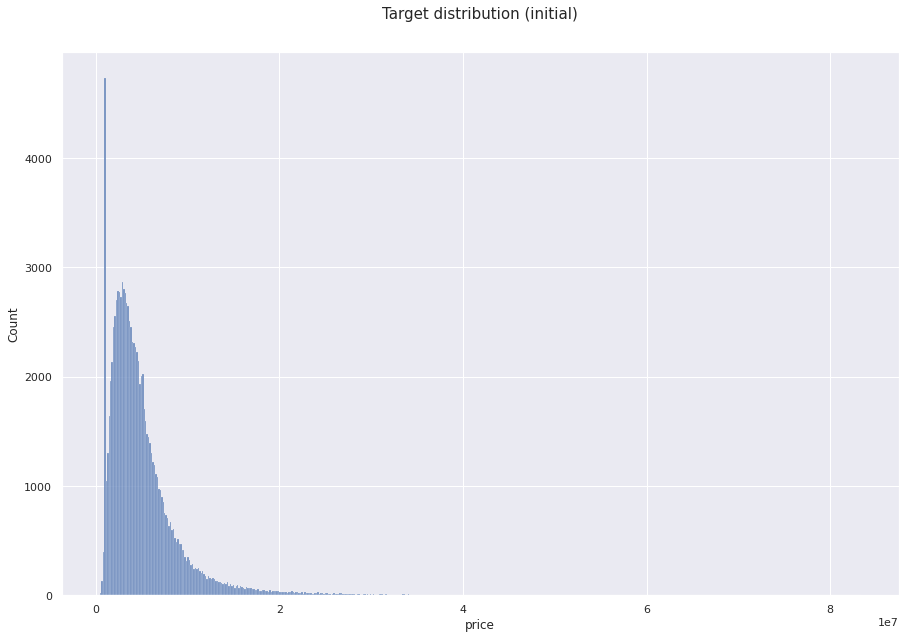

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Target distribution (initial)', y=1.05, size=15)
sns.histplot(clean_dataset['price'])
plt.show()

In [ ]:
clean_dataset[['price']].value_counts(sort=True)

price   
1000000     4007
2489000       34
2948000       33
2970000       33
3091000       30
            ... 
13613000       1
13610000       1
13607000       1
13605000       1
457000         1
Length: 15316, dtype: int64

This is a fairly obvious outbreak (maybe someone filled `NaN`s with constant) and thus should be removed!

Note: Another, better option would be removing the labels and using this data as unlabeled test, but I did not cope with this

However, there is still a really heavy tail, which can possibly distract our models. I have cut it a little bit

In [ ]:
clean_dataset = clean_dataset.drop(clean_dataset.index[clean_dataset.price == 1_000_000])

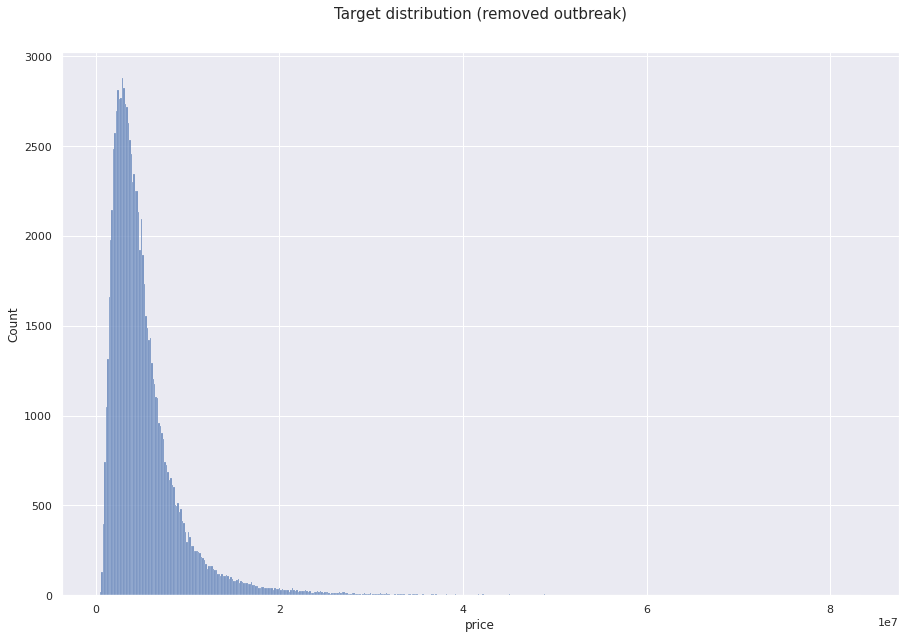

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Target distribution (removed outbreak)', y=1.05, size=15)
sns.histplot(clean_dataset['price'])
plt.show()

In [ ]:
# cut the heavy tail a bit
clean_dataset = clean_dataset.drop(clean_dataset.index[clean_dataset.price > clean_dataset.price.quantile(.999)])

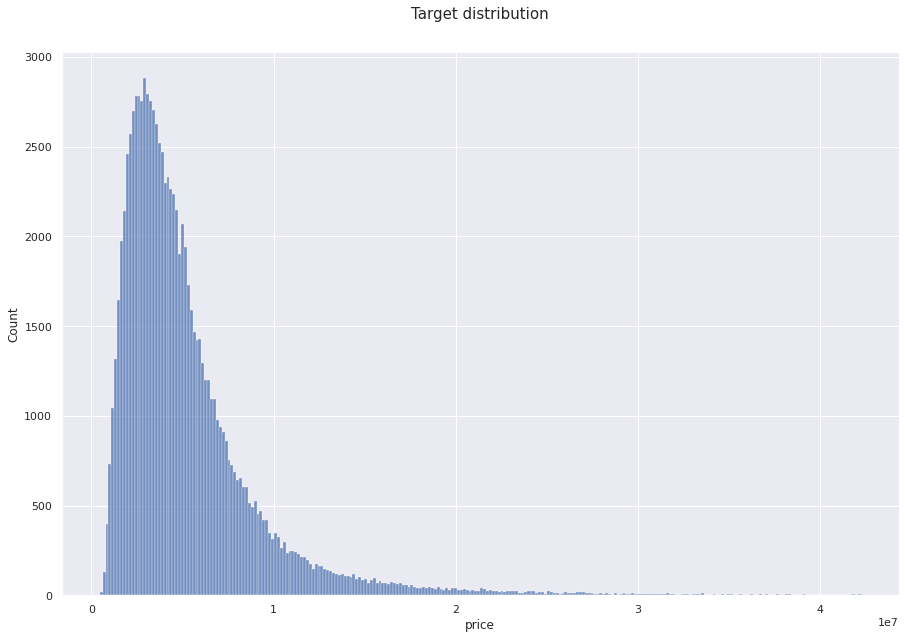

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Target distribution', y=1.05, size=15)
sns.histplot(clean_dataset['price'])
plt.show()

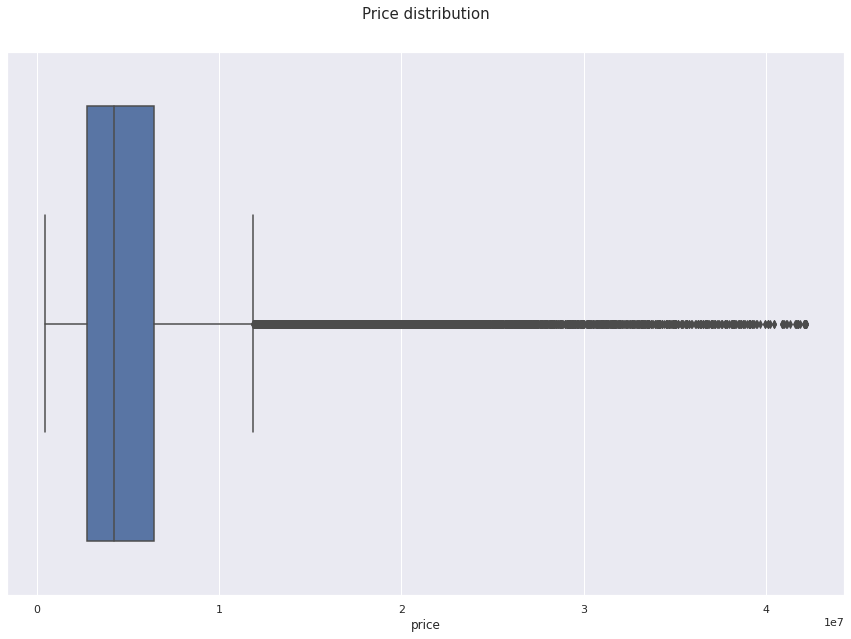

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15, 10))
plt.title('Price distribution', y=1.05, size=15)
sns.boxplot(clean_dataset.price)
plt.show()

The following plots may shed light on the correlations between features and target. Most of these are ordinal and the correlation is quite low, but tree-based solutions can perform really well with such data.

It can be seen that `area` is the most linearly correlated feature

Moreover, some outliers can be observed: there are some in `area` (`>200`), `n_photos` (`>8`) and `rooms` (`>5`). The fact can be confirmed with histograms of these features displayed below

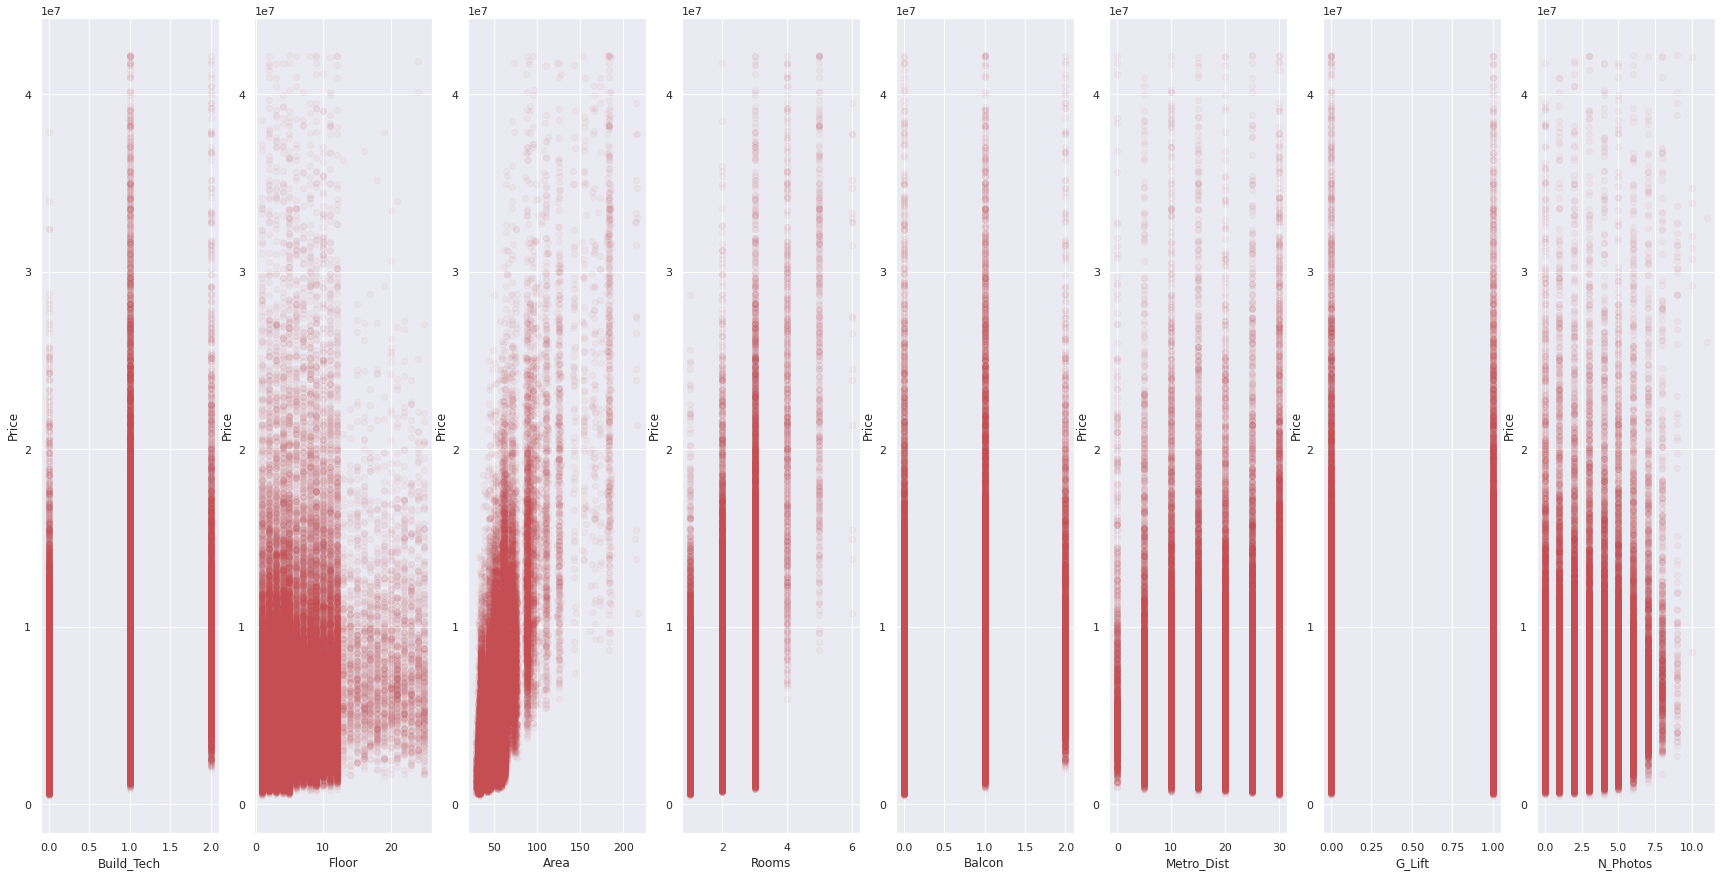

In [ ]:
fig, axis = plt.subplots(1, 8, figsize=(30, 15))
for col, ax in zip(('build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'g_lift', 'n_photos'), axis.ravel()):
  ax.scatter(clean_dataset[[col]], clean_dataset.price, alpha=0.05, c='r')
  ax.set_ylabel('Price')
  ax.set_xlabel(col.title())

In [ ]:
clean_dataset

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,price,kw
0,30,0.0,10,48,2,0,30.0,1.0,4,4252000,1
1,376,1.0,2,53,2,0,30.0,1.0,0,4463000,1
2,549,1.0,8,61,3,1,30.0,0.0,1,4518000,0
3,321,1.0,10,47,1,1,30.0,0.0,6,6785000,1
4,636,0.0,3,58,3,0,25.0,1.0,2,1677000,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,327,0.0,9,37,1,0,25.0,1.0,1,3198000,1
99996,249,0.0,2,33,1,0,20.0,1.0,1,2366000,1
99997,537,0.0,3,61,3,0,30.0,0.0,6,3816000,2
99998,425,1.0,4,35,1,1,10.0,0.0,2,3410000,1


In [ ]:
# sns.pairplot(clean_dataset)

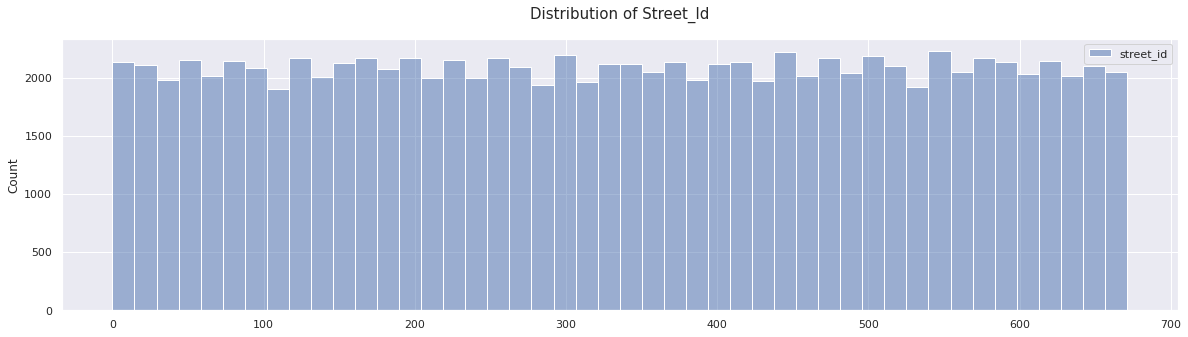

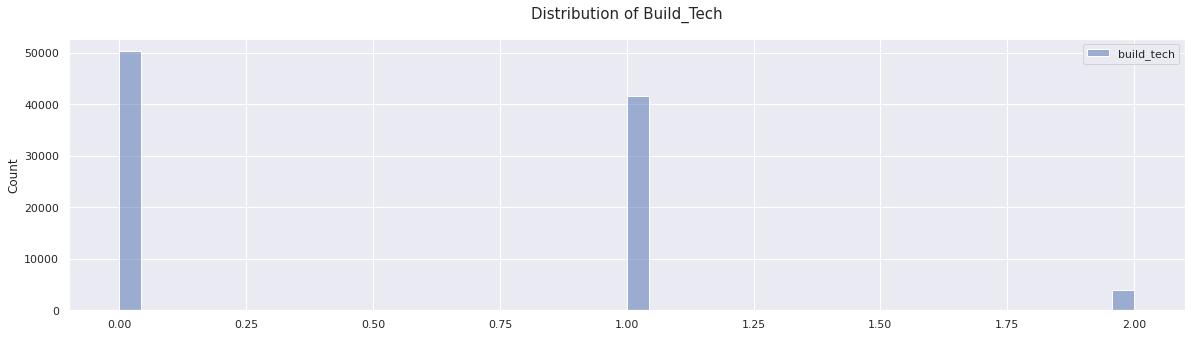

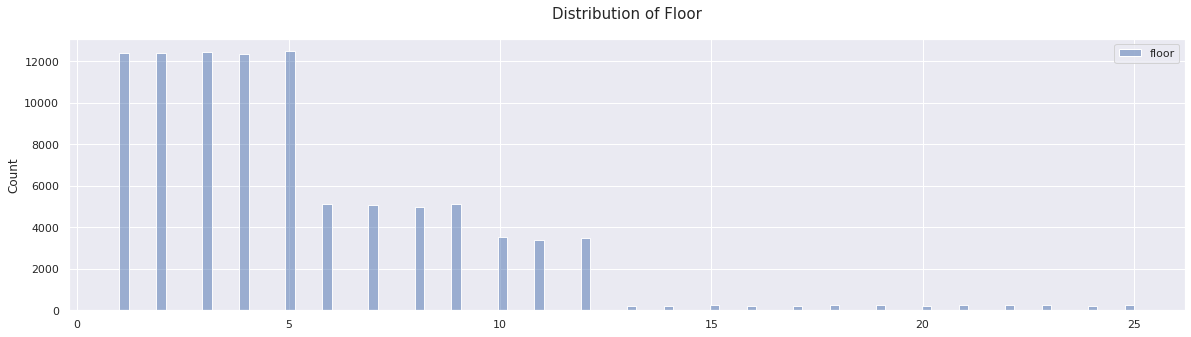

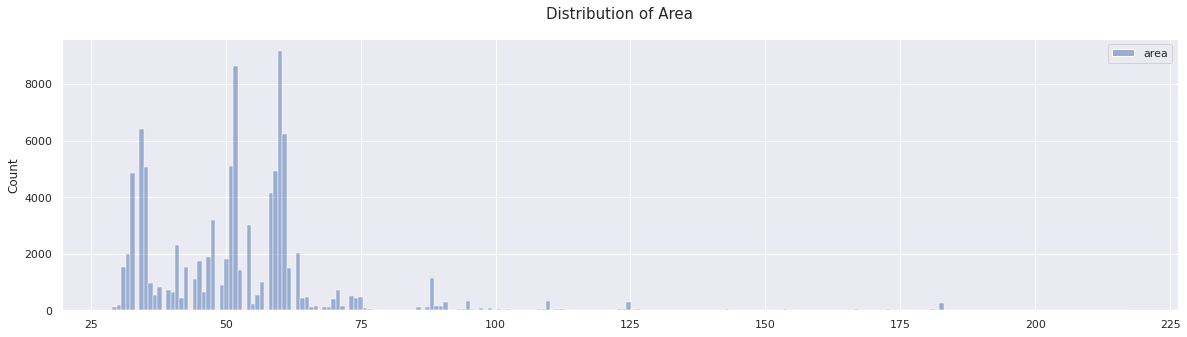

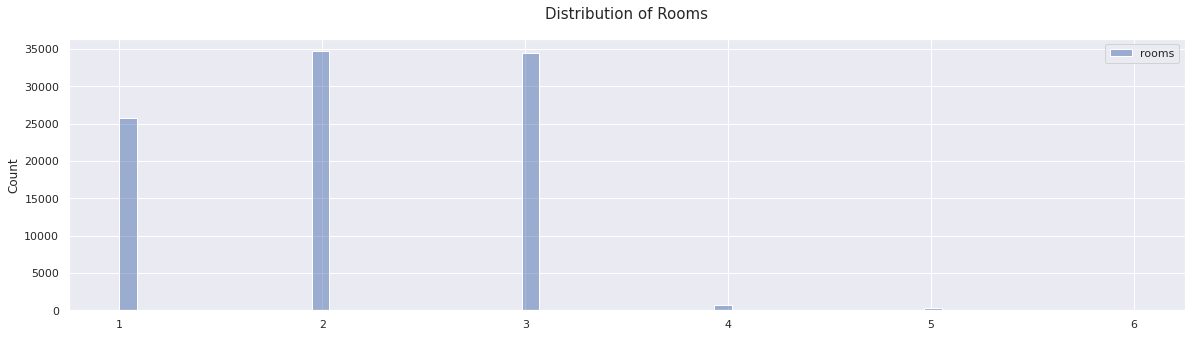

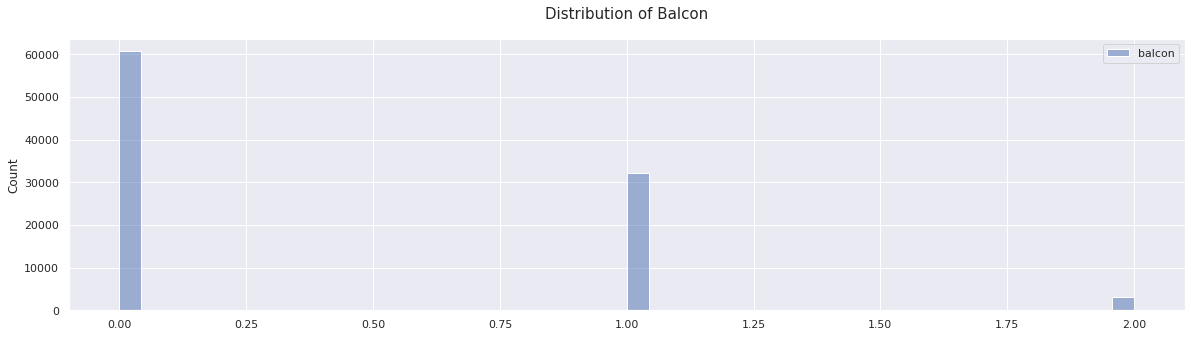

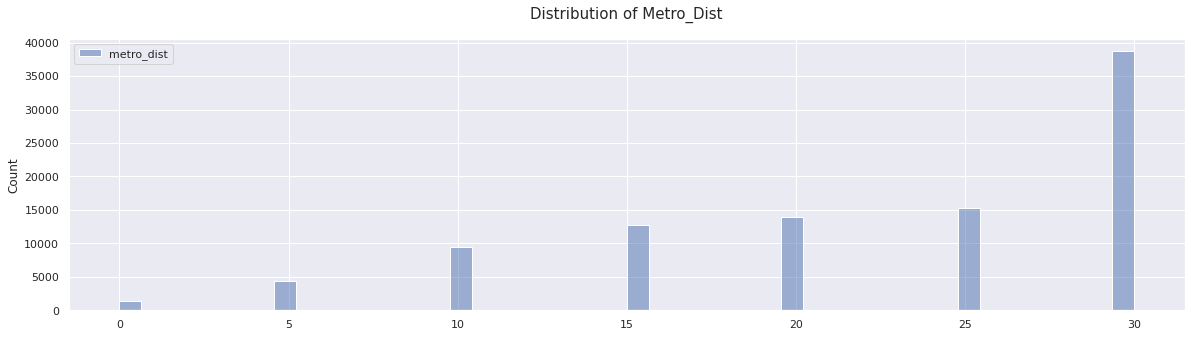

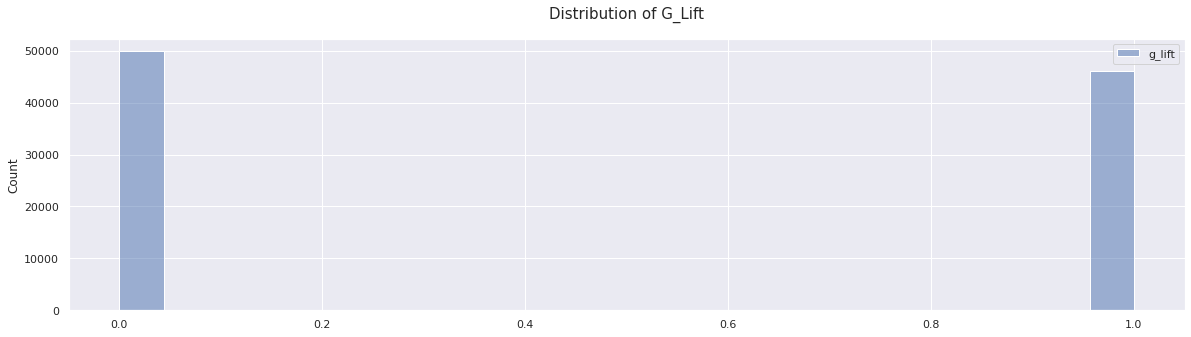

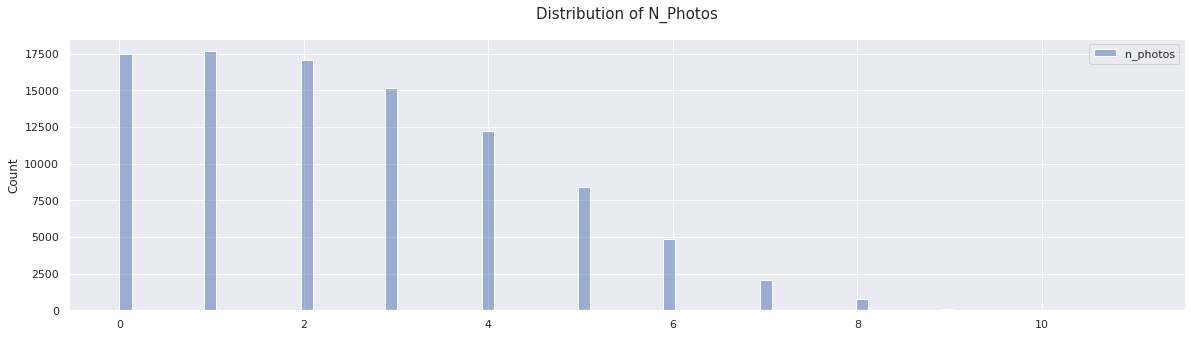

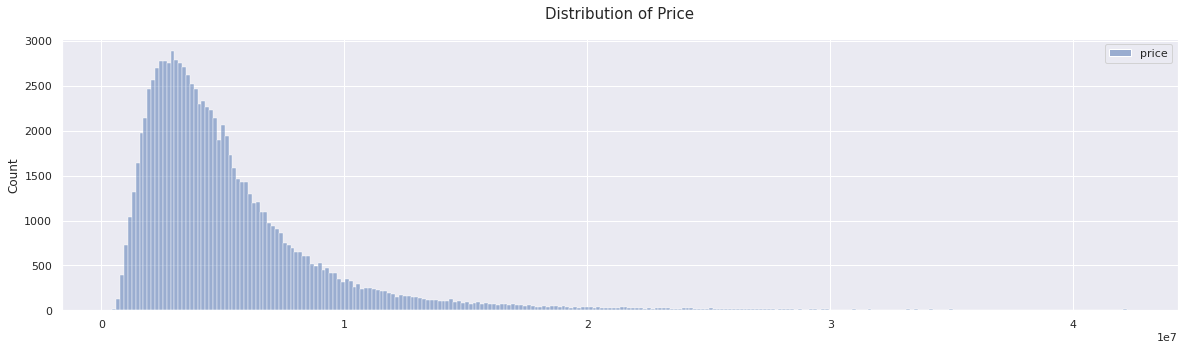

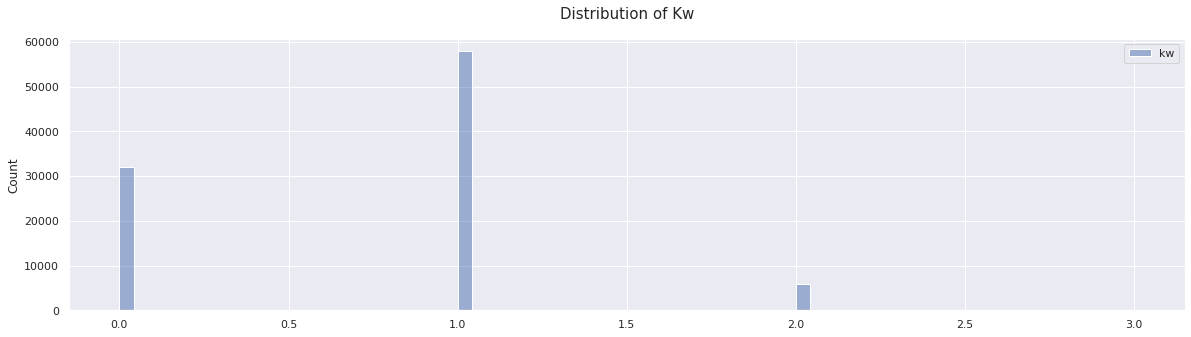

In [ ]:
for col in clean_dataset.columns:
  plt.figure(figsize=(20, 5))
  plt.title(f'Distribution of {col.title()}', y=1.05, size=15)
  sns.histplot(clean_dataset[[col]])
  plt.show()

After looking at the histograms I decided to remove some noisy values

In [ ]:
clean_dataset.drop(clean_dataset.index[clean_dataset.kw == 3], inplace=True)
clean_dataset.drop(clean_dataset.index[clean_dataset.rooms == 6], inplace=True)
clean_dataset.drop(clean_dataset.index[clean_dataset.n_photos > 8], inplace=True)
clean_dataset.drop(clean_dataset.index[clean_dataset.g_lift > 8], inplace=True)
clean_dataset.drop(clean_dataset.index[clean_dataset.area > 200], inplace=True)

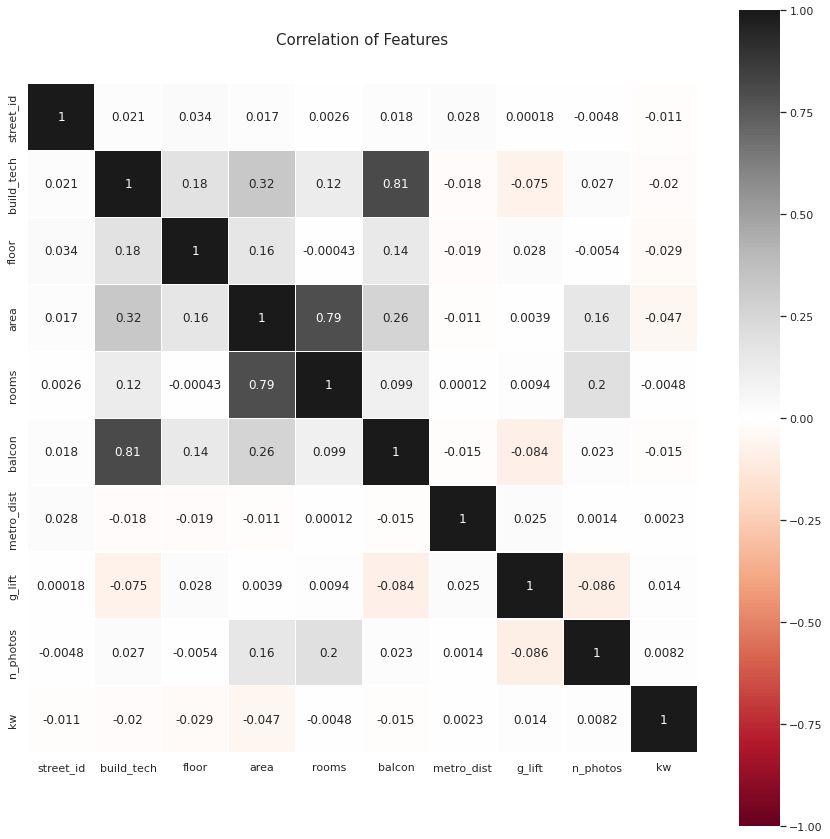

In [ ]:
colormap = plt.cm.RdGy
plt.figure(figsize=(15, 15))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(
    clean_dataset.drop(columns='price').corr(),
    vmin=-1, vmax=1,
    linewidths=0.1,
    square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

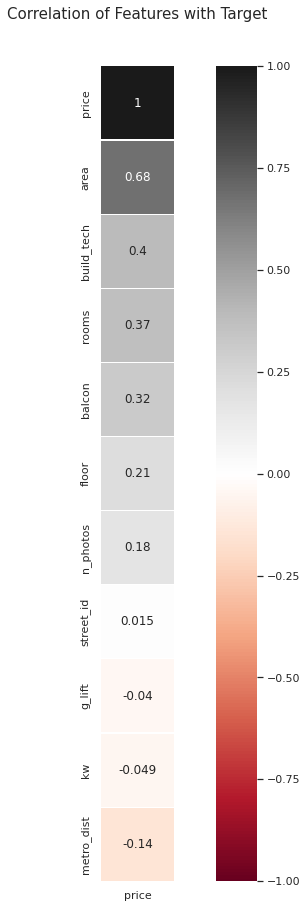

In [ ]:
colormap = plt.cm.RdGy
plt.figure(figsize=(15, 15))
plt.title('Correlation of Features with Target', y=1.05, size=15)
sns.heatmap(
    clean_dataset.corr()[['price']].sort_values(by='price', ascending=False),
    vmin=-1, vmax=1,
    linewidths=0.1,
    square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## **Model evaluation** 🍁

In [ ]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder
    )
from sklearn.linear_model import LassoCV, RidgeCV, SGDRegressor
from sklearn.utils import shuffle
from sklearn import set_config

set_config(display="diagram")

from xgboost import XGBRegressor

For linear models the categorical features should be transformed accordingly (customarily this is done via `OhE` and this time is not an exception) while tree-based models do not require such preprocessing. Thus I create 2 separate preprocessing pipelines. I borrowed this idea from `sklearn` docs on stacking and their approach seems fair enough

In [ ]:
numeric_selector = make_column_selector(dtype_include=np.number)
numeric_tree_pprocessor = SimpleImputer(strategy='median', add_indicator=True)

tree_pprocessor = make_column_transformer(
    (numeric_tree_pprocessor, numeric_selector)
)

numeric_linear_pprocessor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy='median', add_indicator=True)
)

cat_linear_pprocessor = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

linear_pprocessor = make_column_transformer(
    (numeric_linear_pprocessor, ['area', 'metro_dist']),
    (cat_linear_pprocessor, ['street_id', 'build_tech', 'floor', 'rooms', 'balcon', 'g_lift', 'n_photos', 'kw'])
)

lasso_pipeline = make_pipeline(
    linear_pprocessor, LassoCV()
)
linear_pprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['area', 'metro_dist']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['street_id', 'build_tech', 'floor', 'rooms',
                                  'balcon', 'g_lift', 'n_photos', 'kw'])])

In [ ]:
from sklearn.ensemble import (
    RandomForestRegressor,
    HistGradientBoostingRegressor,
    StackingRegressor
)

rf_pipeline = make_pipeline(
    tree_pprocessor, RandomForestRegressor(n_estimators=20, bootstrap=True, n_jobs=-1, random_state=100, criterion='poisson')
)

gbdt_pipeline = make_pipeline(
    tree_pprocessor, HistGradientBoostingRegressor(random_state=100, l2_regularization=0.15, max_leaf_nodes=50, max_depth=100, min_samples_leaf=10)
)

xgb_pipeline = make_pipeline(
    tree_pprocessor, XGBRegressor(random_state=100, n_estimators=400, n_jobs=-1)
)

In [ ]:
sgdr_pipeline = make_pipeline(
    linear_pprocessor, SGDRegressor(
    alpha=1e-4,
    max_iter=1000,
    random_state=100)
)

best_gbdt_pipeline = make_pipeline(
    HistGradientBoostingRegressor(
        random_state=100,
        l2_regularization=0.0,
        max_depth=6,
        max_iter=1000,
        categorical_features=[ 1, 2, 4, 5, 6, 7, 8, 9])
)

estimators = [
  ('SGDR-1', sgdr_pipeline),
  ('HBGB', best_gbdt_pipeline),
  ('SGDR-2', sgdr_pipeline)
]

stacking_regressor = StackingRegressor(
    estimators=estimators, 
    final_estimator=HistGradientBoostingRegressor(
        random_state=100,
        l2_regularization=0.0,
        max_depth=6,
        max_iter=1000,))
stacking_regressor

StackingRegressor(estimators=[('SGDR-1',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('robustscaler',
                                                                                                  RobustScaler()),
                                                                                                 ('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True,
                                                                                                                strategy='median'))]),
                                                                                 ['area',
                                                                                  'metro_dist']),
                                                                                ('pipeline-2',
                                                                                 Pipeline(steps=[('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'...
                                                                                                                strategy='median'))]),
                                                                                 ['area',
                                                                                  'metro_dist']),
                                                                                ('pipeline-2',
                                                                                 Pipeline(steps=[('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['street_id',
                                                                                  'build_tech',
                                                                                  'floor',
                                                                                  'rooms',
                                                                                  'balcon',
                                                                                  'g_lift',
                                                                                  'n_photos',
                                                                                  'kw'])])),
                                               ('sgdregressor',
                                                SGDRegressor(random_state=100))]))],
                  final_estimator=HistGradientBoostingRegressor(max_depth=6,
                                                                max_iter=1000,
                                                                random_state=100))

In [ ]:
features = clean_dataset.drop(columns=['price'])
target = clean_dataset.price
features, target = shuffle(features, target, random_state=100)

In [ ]:
augmented_features = features.copy()
target_log = np.log(target)

In [ ]:
def make_augmented_features(initial_features):
  augmented_features = initial_features.copy()
  augmented_features['SGDR'] = make_regression(sgdr_pipeline, features, target, 'SGDR')
  augmented_features['RF'] = make_regression(best_gbdt_pipeline, augmented_features, target, 'RF+SGDR')
  augmented_features['HBGB'] = make_regression(best_gbdt_pipeline, augmented_features, target, 'HBGB+RF+SGDR')
  return augmented_features

In [ ]:
import time
from sklearn.model_selection import cross_validate, cross_val_predict

def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


def make_regression(pipeline, features, target, name='some pipeline'):
  fig, ax = plt.subplots(1, 1, figsize=(15, 15))

  start_time = time.time()
  score = cross_validate(
      pipeline, features, target, scoring=["r2", "neg_mean_absolute_error"], n_jobs=-1, verbose=0
  )
  elapsed_time = time.time() - start_time

  y_pred = cross_val_predict(pipeline, features, target, n_jobs=-1, verbose=0)

  plot_regression_results(
      ax,
      target,
      y_pred,
      name,
      (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
          np.mean(score["test_r2"]),
          np.std(score["test_r2"]),
          -np.mean(score["test_neg_mean_absolute_error"]),
          np.std(score["test_neg_mean_absolute_error"]),
      ),
      elapsed_time,
  )

  plt.show()
  return y_pred

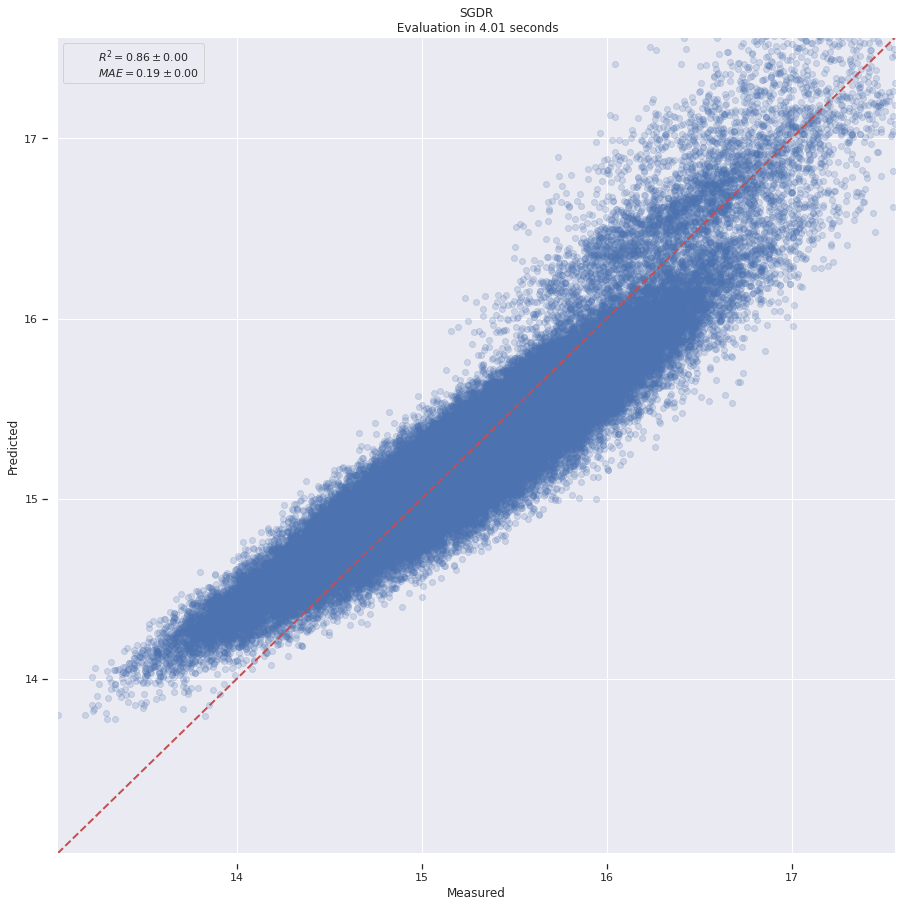

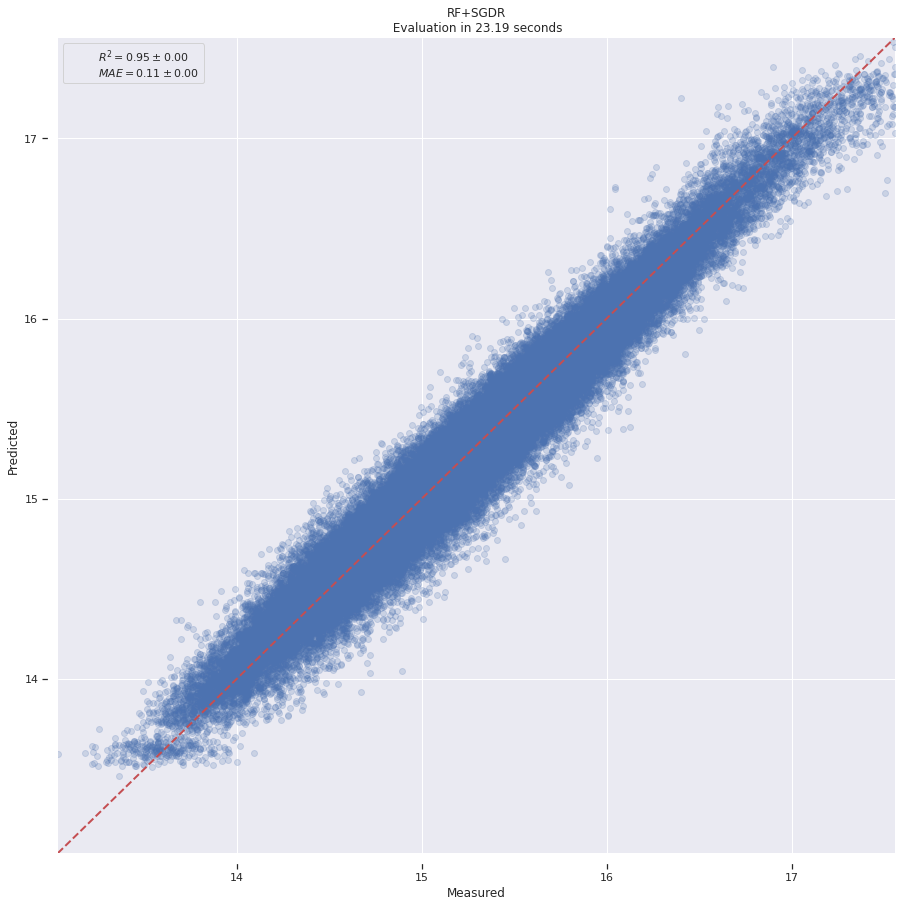

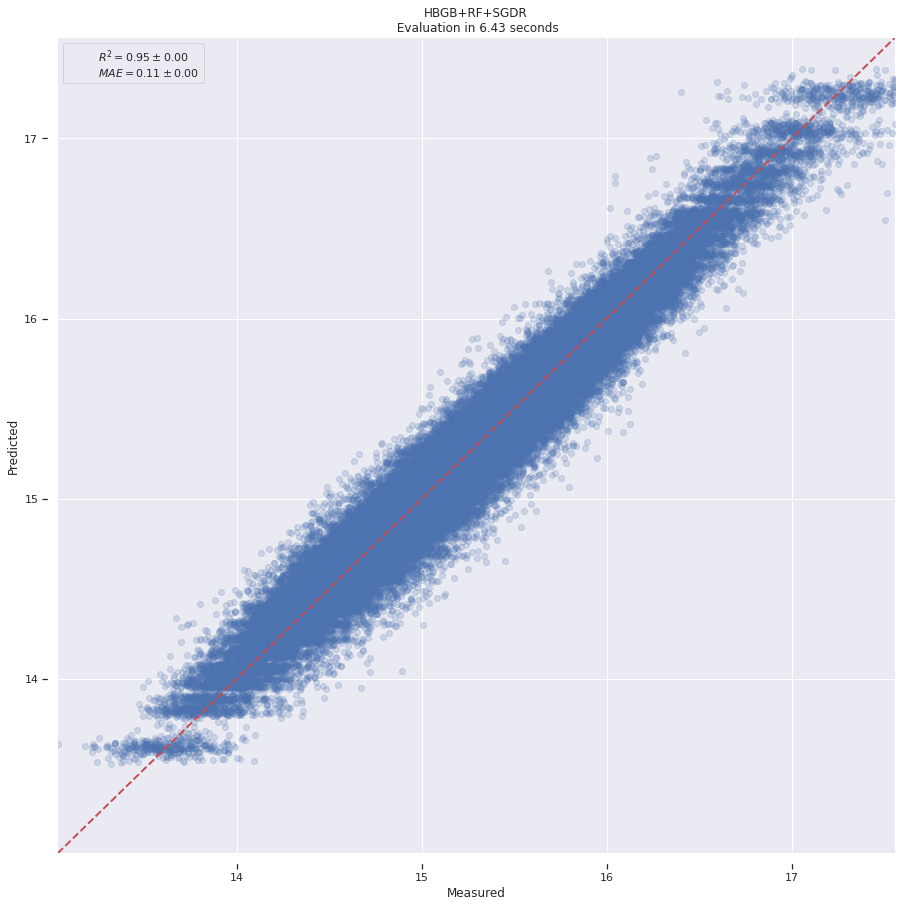

In [ ]:
augmented_features['SGDR'] = make_regression(sgdr_pipeline, features, target_log, 'SGDR')
augmented_features['RF'] = make_regression(best_gbdt_pipeline, augmented_features, target_log, 'RF+SGDR')
augmented_features['HBGB'] = make_regression(best_gbdt_pipeline, augmented_features, target_log, 'HBGB+RF+SGDR')

The figure below illustrates performance of linear model, `SGDRegressor`, with appropriate feature preprocessing. Without extraction of categorical features the score is twice bigger!

In [ ]:
for col in ('build_tech', 'metro_dist', 'g_lift'):
  features[col] = features[col].map(lambda x: int(x))
features

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw
61530,519,1,12,50,1,0,30,0,1,0
40292,70,1,3,51,2,1,10,1,2,1
89668,536,1,11,88,3,1,10,0,4,0
6788,96,0,5,58,3,0,20,1,5,0
62088,451,1,10,53,2,1,30,0,0,1
...,...,...,...,...,...,...,...,...,...,...
68649,447,2,23,88,3,2,15,1,4,1
81221,260,0,5,48,2,0,15,1,2,0
83352,50,1,5,60,3,1,30,0,0,0
58656,53,1,7,34,1,1,25,0,2,1


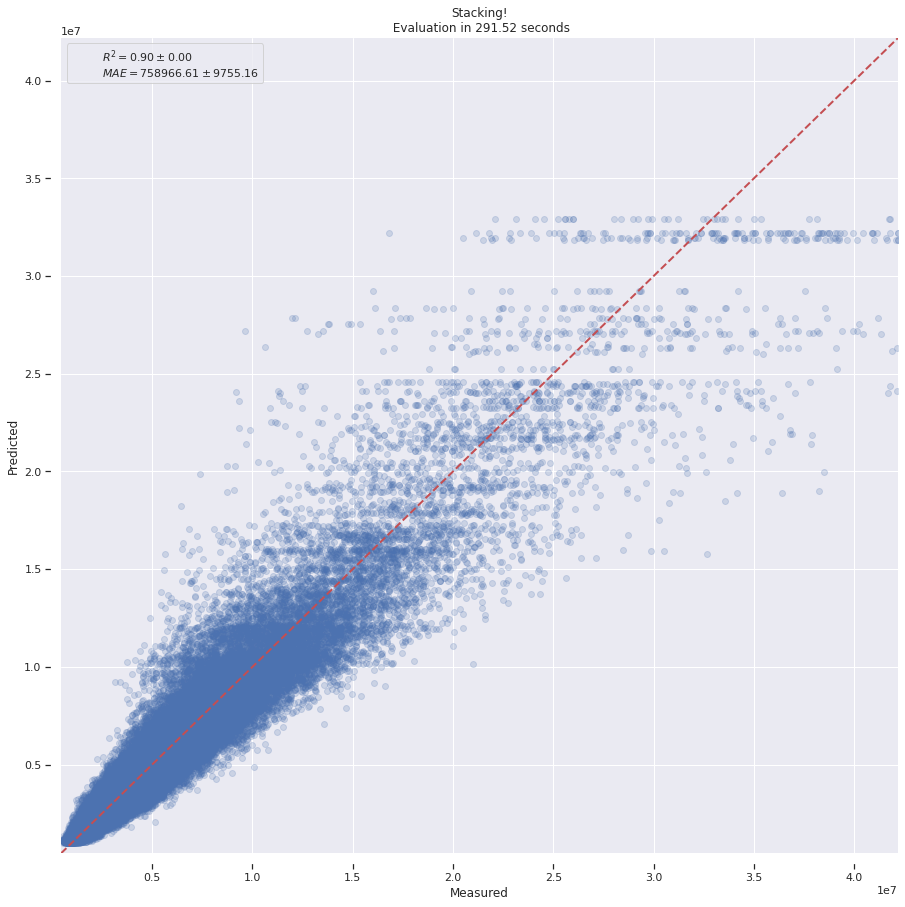

array([ 3764834.39953894,  3173211.40959112, 11903933.24187811, ...,
        2775765.1163041 ,  3136143.48309562,  2520105.45414133])

In [ ]:
make_regression(stacking_regressor, features, target, name='Stacking!')

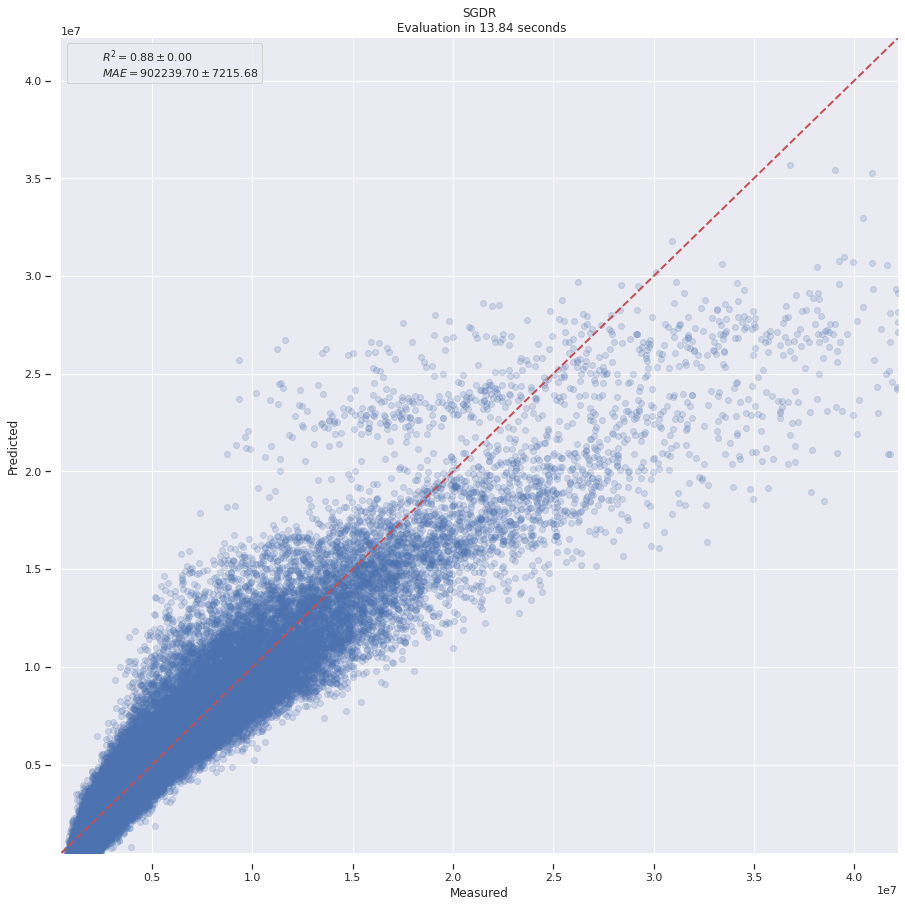

In [ ]:
sgdr_pipeline = make_pipeline(
    linear_pprocessor, SGDRegressor(
    alpha=1e-4,
    max_iter=500,
    random_state=100)
)

sgdr_feature = make_regression(sgdr_pipeline, features, target, name='SGDR')

I add this new feature to the others and train more complicated regressors on the new dataset

In [ ]:
agregated_features = features.copy()
agregated_features['price_pred'] = sgdr_feature

The following code illustrates the initial scores I achieved using `RandomForestRegressor`, `SGDRegressor`, `XGBoostRegressor` and `HistGradientBoostingRegressor`. These are really bad

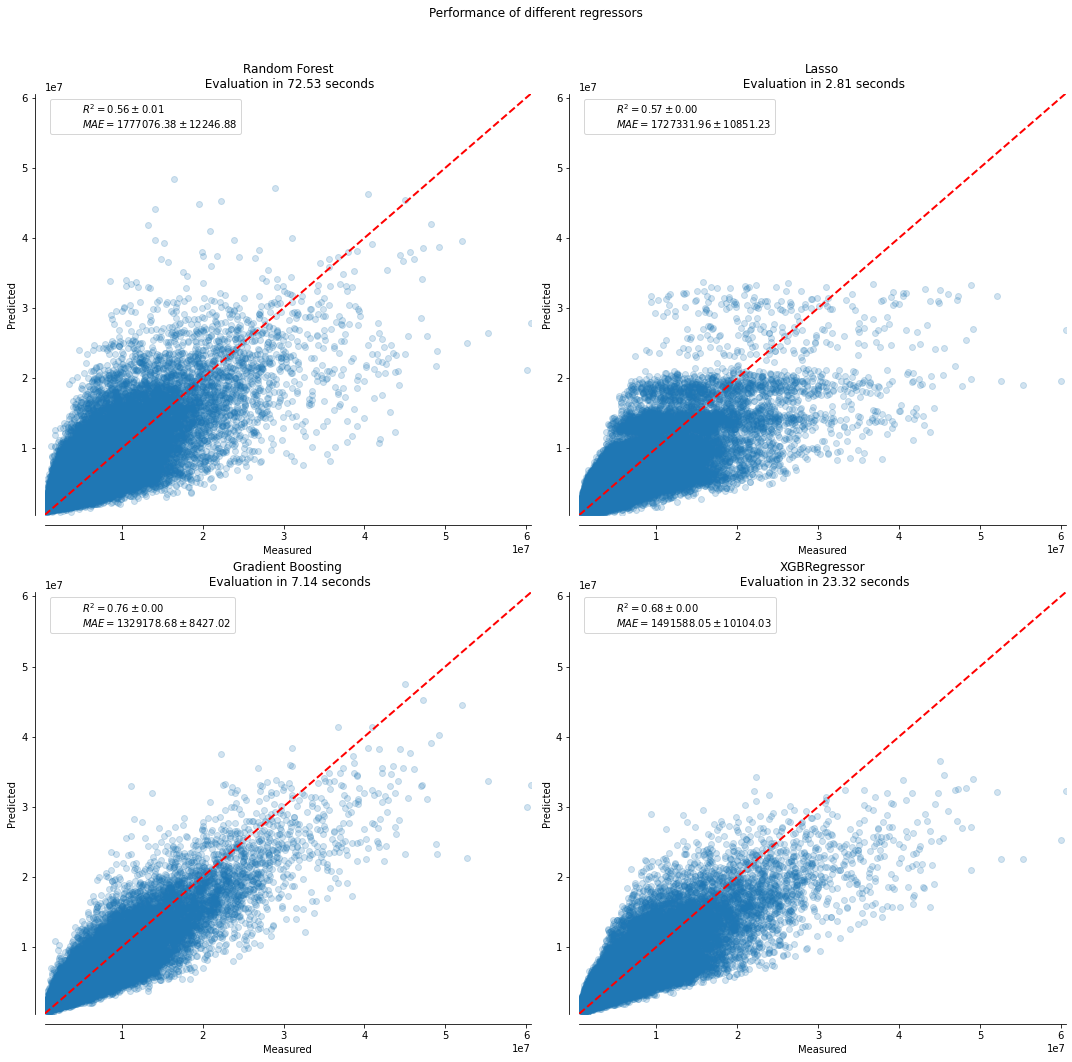

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators
):
    start_time = time.time()
    score = cross_validate(
        est, features, target, scoring=["r2", "neg_mean_absolute_error"], n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, features, target, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax,
        target,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Performance of different regressors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

Next, I tried using `CatBoost`

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
import catboost as cb
import lightgbm as lgb

In [ ]:
agregated_features

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw,price_pred
61530,519,1,12,50,1,0,30,0,1,0,4.190992e+06
40292,70,1,3,51,2,1,10,1,2,1,3.375329e+06
89668,536,1,11,88,3,1,10,0,4,0,1.151266e+07
6788,96,0,5,58,3,0,20,1,5,0,4.168073e+06
62088,451,1,10,53,2,1,30,0,0,1,6.675775e+06
...,...,...,...,...,...,...,...,...,...,...,...
68649,447,2,23,88,3,2,15,1,4,1,1.435500e+07
81221,260,0,5,48,2,0,15,1,2,0,5.146885e+06
83352,50,1,5,60,3,1,30,1,0,0,2.675898e+06
58656,53,1,7,34,1,1,25,0,2,1,3.325479e+06


Categorical features provided to `CatBoost` model should be either `str` or `int` (expectedly), so one should map floats from the dataset to ints

In [ ]:
for col in ('build_tech', 'metro_dist', 'g_lift'):
  agregated_features[col] = agregated_features[col].map(lambda x: int(x))

In [ ]:
for col in ('build_tech', 'metro_dist', 'g_lift'):
  augmented_features[col] = augmented_features[col].map(lambda x: int(x))
augmented_features

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw,SGDR,RF,HBGB
61530,519,1,12,50,1,0,30,0,1,0,15.236534,15.174892,15.165990
40292,70,1,3,51,2,1,10,1,2,1,15.102192,14.880720,14.875750
89668,536,1,11,88,3,1,10,0,4,0,16.474275,16.083415,16.078755
6788,96,0,5,58,3,0,20,1,5,0,15.174315,15.075369,15.082561
62088,451,1,10,53,2,1,30,0,0,1,15.611045,15.608729,15.616768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68649,447,2,23,88,3,2,15,1,4,1,16.651875,16.581006,16.591482
81221,260,0,5,48,2,0,15,1,2,0,15.211680,15.449424,15.418937
83352,50,1,5,60,3,1,30,0,0,0,14.765080,14.494456,14.484436
58656,53,1,7,34,1,1,25,0,2,1,15.031540,14.911953,14.910882


In [ ]:
cat_features = ['build_tech', 'floor', 'rooms', 'balcon', 'metro_dist', 'g_lift', 'n_photos', 'kw']

cat = cb.CatBoostRegressor(
    iterations=1000,
    learning_rate=5e-2,
    loss_function='MAE',
    random_seed=100,
    cat_features=cat_features
)

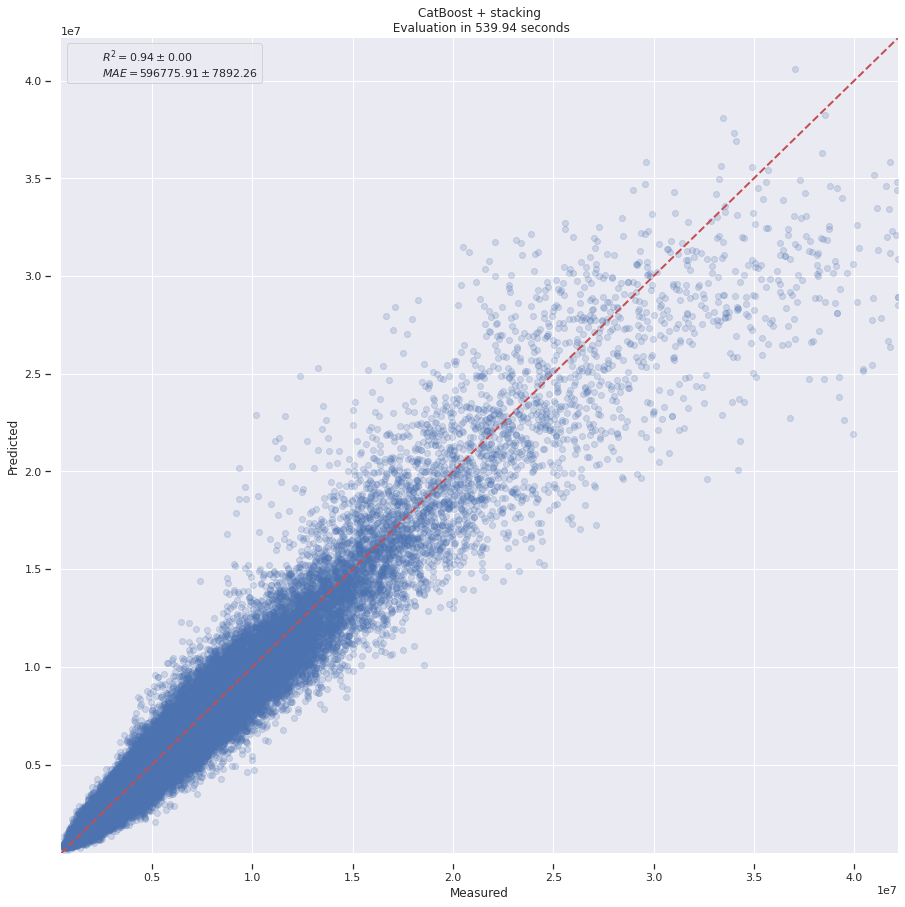

array([3862608.26692338, 2587899.09882433, 9951099.1092747 , ...,
       2305084.36619535, 3167094.70465973, 2224103.16715623])

In [ ]:
make_regression(cat, agregated_features, target, 'CatBoost + stacking')

The model above was training really long but did not outperform `HBGB` dramastically, not to mention that the latter is training in **seconds**, not minutes

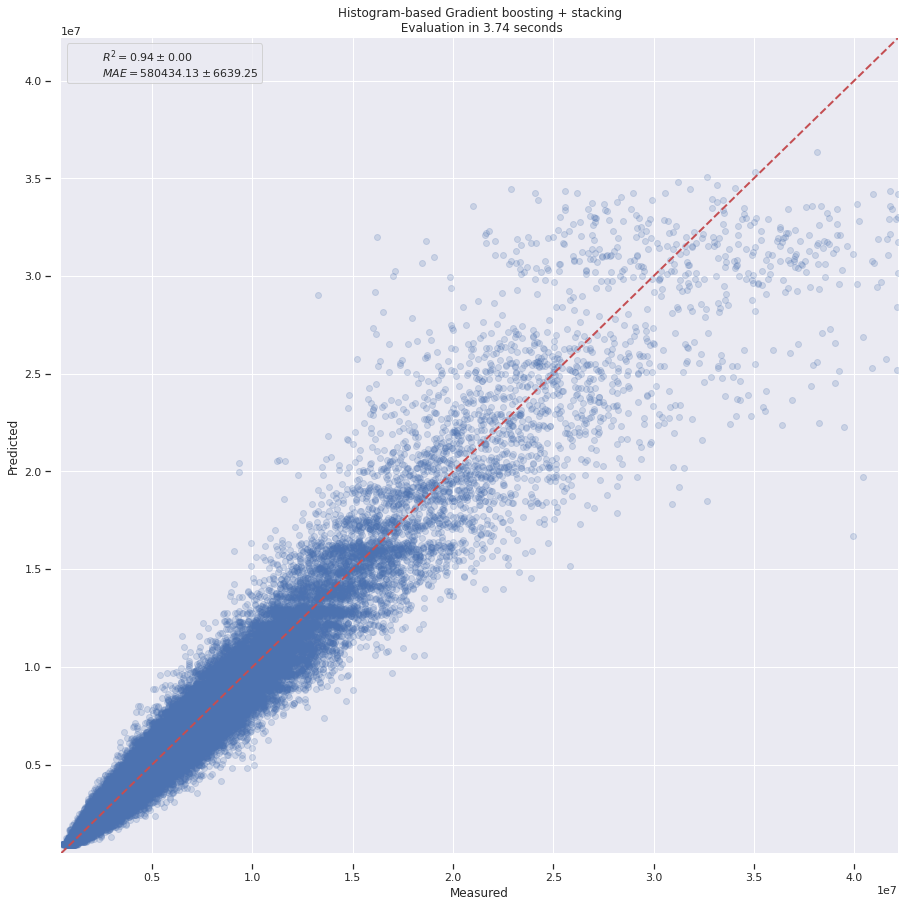

array([3902658.89998056, 2936661.21281877, 9675756.55311615, ...,
       1997306.68967402, 3050424.22176762, 2303909.1195761 ])

In [ ]:
best_gbdt_pipeline = make_pipeline(
    HistGradientBoostingRegressor(
        random_state=100,
        l2_regularization=0.0,
        max_depth=6,
        max_iter=1000,
        categorical_features=[ 1, 2, 4, 5, 6, 7, 8, 9])
)

make_regression(best_gbdt_pipeline, augmented_features, target, name='Histogram-based Gradient boosting + stacking')

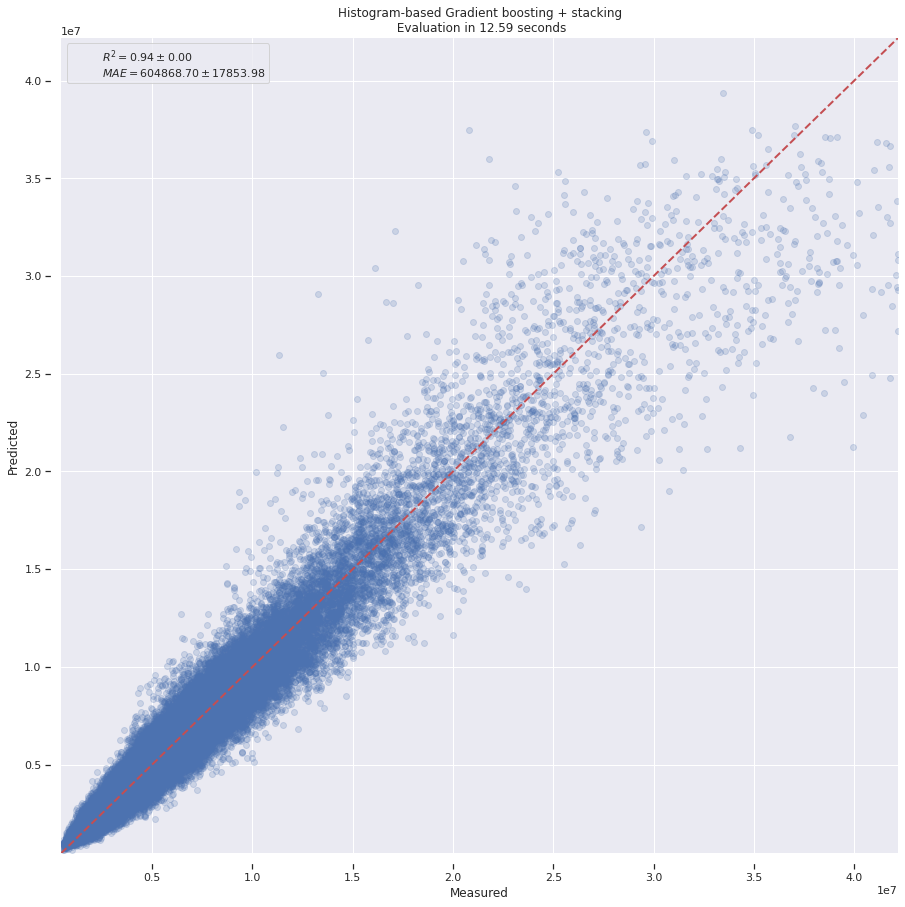

array([4125543.21094509, 2725536.0470402 , 9771060.42342305, ...,
       2490251.13461764, 3342723.10918974, 2386947.10355509])

In [ ]:
best_gbdt_pipeline = make_pipeline(
    HistGradientBoostingRegressor(
        random_state=100,
        l2_regularization=0.0,
        max_depth=6,
        max_iter=1000,
        categorical_features=[ 1, 2, 4, 5, 6, 7, 8, 9])
)

make_regression(best_gbdt_pipeline, agregated_features, target, name='Histogram-based Gradient boosting + stacking')

## **Submission** ⏰

In [ ]:
test_dataset = test_dataset_raw.copy()

test_dataset.drop(columns=['id', 'date'], inplace=True)

kw_cols = [f'kw{i}' for i in range(1, 14)]
test_dataset['kw'] = np.sum(test_dataset[kw_cols], axis=1)
test_dataset.drop(columns=kw_cols, inplace=True)

test_dataset

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw
0,134,NaN,2,35,1,0,30.0,1.0,1,2
1,630,NaN,5,33,1,0,30.0,NaN,1,0
2,437,1.0,1,60,3,1,NaN,NaN,5,1
3,30,1.0,7,71,2,1,25.0,0.0,3,0
4,358,1.0,4,52,2,1,30.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...
99995,68,0.0,5,54,3,0,10.0,NaN,6,1
99996,121,NaN,11,57,3,0,25.0,0.0,3,0
99997,342,NaN,1,52,2,1,30.0,NaN,7,0
99998,583,1.0,3,61,3,0,20.0,1.0,3,0


In [ ]:
dirty_cols = ['metro_dist', 'build_tech', 'g_lift']
other_cols = list(set(test_dataset.columns) - set(dirty_cols))

for col in dirty_cols:
  test_dataset[[col]] = fill_missing_ordinal_values(test_dataset, col, other_cols)
  other_cols.append(col)

Filling missing values for column metro_dist
Found 94954 present values
Found 5046 missing (NaN) values
Fitting present values... Done, elapsed time 57.36 seconds
Predicting and filling missing values... Done
Filling missing values for column build_tech
Found 70032 present values
Found 29968 missing (NaN) values
Fitting present values... Done, elapsed time 35.55 seconds
Predicting and filling missing values... Done
Filling missing values for column g_lift
Found 69753 present values
Found 30247 missing (NaN) values
Fitting present values... Done, elapsed time 50.49 seconds
Predicting and filling missing values... Done


In [ ]:
test_dataset[dirty_cols].isnull().mean().apply(lambda x: f'{(x*100):.2f}% Missing Rows')

metro_dist    0.00% Missing Rows
build_tech    0.00% Missing Rows
g_lift        0.00% Missing Rows
dtype: object

Initially I will predict the price via `SGDRegressor` (trained on train dataset, of course). Then this new meta-feature is appended to the test dataset an taken into account during prediction. The meta-regressors (`CatBoostRegressor` or `HistGradientBoostingRegressor`) are trained on the agregated dataset. This results into `MAE` drop almost in a half (from `~1.3m` down to `~600k`)! Notably, the cross-validation metrics of latter regressor are a tiny bit better, but the score on Kaggle is somehow worse (the diff is almost same, about `5-8k`)

In [ ]:
for col in ('build_tech', 'metro_dist', 'g_lift'):
  test_dataset[col] = test_dataset[col].map(lambda x: int(x))
test_dataset

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw
0,134,0,2,35,1,0,30,1,1,2
1,630,0,5,33,1,0,30,1,1,0
2,437,1,1,60,3,1,30,0,5,1
3,30,1,7,71,2,1,25,0,3,0
4,358,1,4,52,2,1,30,0,0,1
...,...,...,...,...,...,...,...,...,...,...
99995,68,0,5,54,3,0,10,1,6,1
99996,121,0,11,57,3,0,25,0,3,0
99997,342,1,1,52,2,1,30,0,7,0
99998,583,1,3,61,3,0,20,1,3,0


In [ ]:
sgdr_pipeline.fit(features, target_log)
test_dataset['SGDR'] = sgdr_pipeline.predict(test_dataset)
rf_pipeline.fit(augmented_features.drop(columns=['RF', 'HBGB']), target_log)
test_dataset['RF'] = rf_pipeline.predict(test_dataset)
best_gbdt_pipeline.fit(augmented_features.drop(columns='HBGB'), target_log)
test_dataset['HBGB'] = best_gbdt_pipeline.predict(test_dataset)

best_gbdt_pipeline.fit(augmented_features, target_log)
y_pred = best_gbdt_pipeline.predict(test_dataset)

Again, categorical features provided to `CatBoost` should be either `str` or `int` (expectedly), so one should map floats from the dataset to ints

`CatBoost` writes logs that kinda describe my life lmao

In [ ]:
augmented_features

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw,SGDR,RF,HBGB
61530,519,1,12,50,1,0,30,0,1,0,15.236534,15.174892,15.165990
40292,70,1,3,51,2,1,10,1,2,1,15.102192,14.880720,14.875750
89668,536,1,11,88,3,1,10,0,4,0,16.474275,16.083415,16.078755
6788,96,0,5,58,3,0,20,1,5,0,15.174315,15.075369,15.082561
62088,451,1,10,53,2,1,30,0,0,1,15.611045,15.608729,15.616768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68649,447,2,23,88,3,2,15,1,4,1,16.651875,16.581006,16.591482
81221,260,0,5,48,2,0,15,1,2,0,15.211680,15.449424,15.418937
83352,50,1,5,60,3,1,30,0,0,0,14.765080,14.494456,14.484436
58656,53,1,7,34,1,1,25,0,2,1,15.031540,14.911953,14.910882


In [ ]:
best_gbdt_pipeline.fit(augmented_features, target)
y_pred = best_gbdt_pipeline.predict(test_dataset)

submission = test_dataset_raw[['id']]
submission['price'] = np.round(y_pred, 0)

In [ ]:
test_dataset['price_pred'] = sgdr_feature

cat.fit(augmented_features, target, plot=True)
y_pred = cat.predict(test_dataset)

submission = test_dataset_raw[['id']]
submission['price'] = np.round(y_pred, 0)

In [ ]:
submission.set_index('id')

,price
id,
100000,1999727.0
100001,810170.0
100002,12181261.0
100003,14138857.0
100004,11563604.0
...,...
199995,4983031.0
199996,3859721.0
199997,8221139.0


In [ ]:
from google.colab import files
submission.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The figure below contains the initial scores on all models, without any particular feature-engineering or something

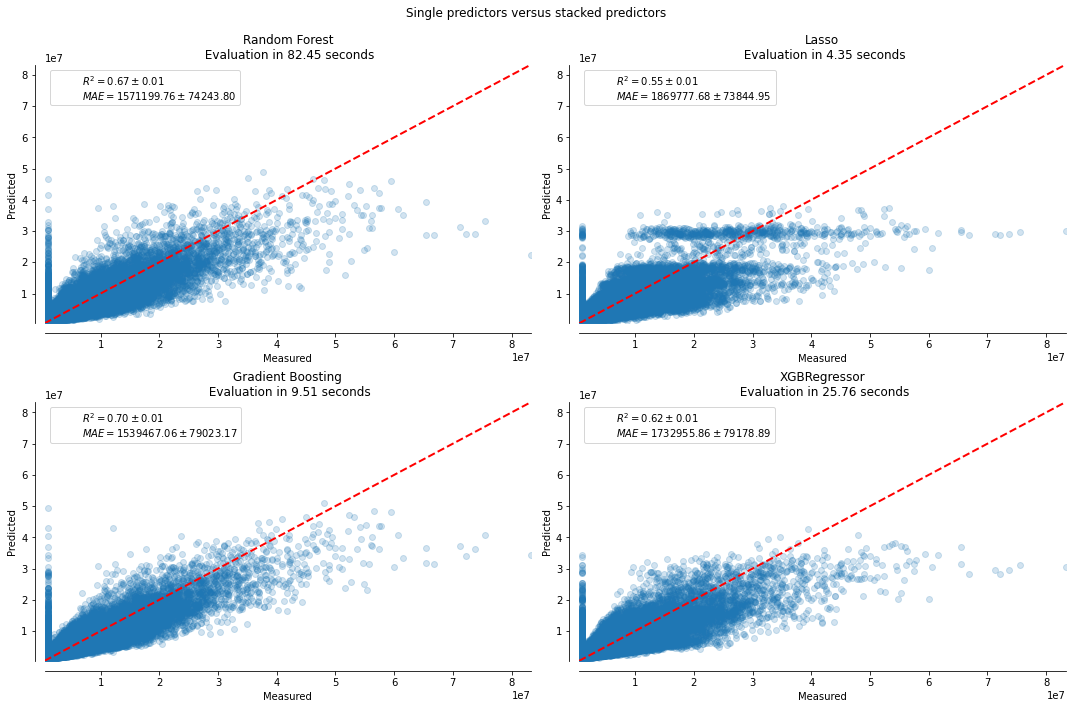

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators
):
    start_time = time.time()
    score = cross_validate(
        est, features, target, scoring=["r2", "neg_mean_absolute_error"], n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, features, target, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax,
        target,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()